# Tutorial: finding wells

We're going to try and find some wells!

We will download the relevant data using this package (python-sa-gwdata) -- importable as ``sa_gwdata`` -- and use some other packages for other things:

- matplotlib, numpy, pandas - used in the background

In [1]:
import sa_gwdata

import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

Start a session for working in, and optionally set a working coordinate reference system (CRS). I'm going to use [SA Lambert GDA2020](https://epsg.io/8059), which is in eastings and northings and covers the whole state. You can pick any!

In [2]:
session = sa_gwdata.WaterConnectSession(working_crs='EPSG:8059')

## Search for wells by suburb

Where do we start? Let's download a list of all wells in Semaphore as a start.

In [17]:
semaphore_wells = session.search_by_suburb("semaphore")

This returns a ``sa_gwdata.Response`` object, which you can then use to retrieve a ``geopandas.GeoDataFrame``:

In [18]:
semaphore_wells

In [19]:
wells = semaphore_wells.gdf()
wells.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   dhno               144 non-null    int64   
 1   lat                144 non-null    float64 
 2   lon                144 non-null    float64 
 3   mapnum             144 non-null    float64 
 4   unit_no            144 non-null    object  
 5   max_depth          142 non-null    float64 
 6   aq_mon             136 non-null    object  
 7   swl                103 non-null    float64 
 8   tds                121 non-null    float64 
 9   class              144 non-null    object  
 10  title_prefix       134 non-null    object  
 11  title_volume       134 non-null    object  
 12  title_folio        134 non-null    object  
 13  hund               144 non-null    object  
 14  parcel             134 non-null    object  
 15  parcelno           134 non-null    object  
 16  

Plot these wells with a background map:

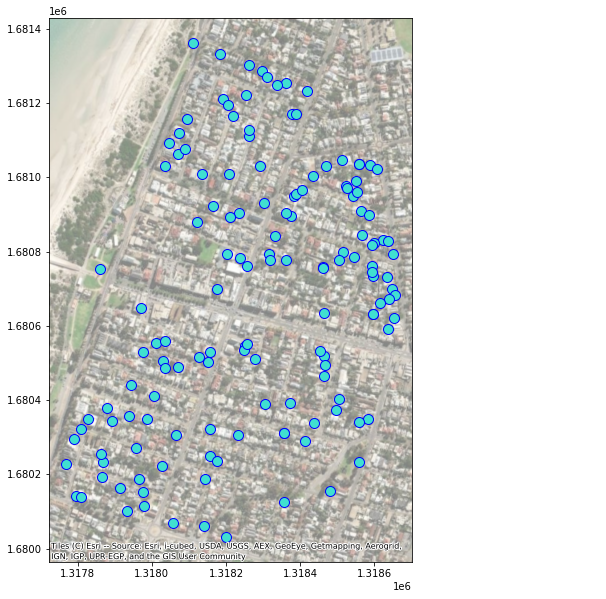

In [29]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
wells.geometry.plot(fc='turquoise', ec='b', marker='o', markersize=100, ax=ax)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)

The field "aq_mon" will contain data on which aquifer the wells is completed in:

In [31]:
wells.aq_mon.fillna("NA").value_counts()

Qhcks         132
NA              8
Qhck            2
Tomw(T1)        1
Qhcks+Qpah      1
Name: aq_mon, dtype: int64

There's only one well monitoring the T1 aquifer so let's expand our search to include nearby suburbs.

In [34]:
wells = pd.concat(
    [
        session.search_by_suburb(suburb).gdf() for suburb in 
        ("semaphore", "semaphore south", "semaphore park", "ethelton", "largs bay", "birkenhead")
    ]
)

In [36]:
wells.aq_mon.fillna("NA").value_counts()

Qhcks         647
Qhck          359
NA             50
Qpah           41
Tomw(T1)        5
Qhcks+Qpah      1
Tomw(T2)        1
Name: aq_mon, dtype: int64

That's better

In [37]:
t_wells = wells[wells.aq_mon.isin(["Tomw(T1)", "Tomw(T2)"])]

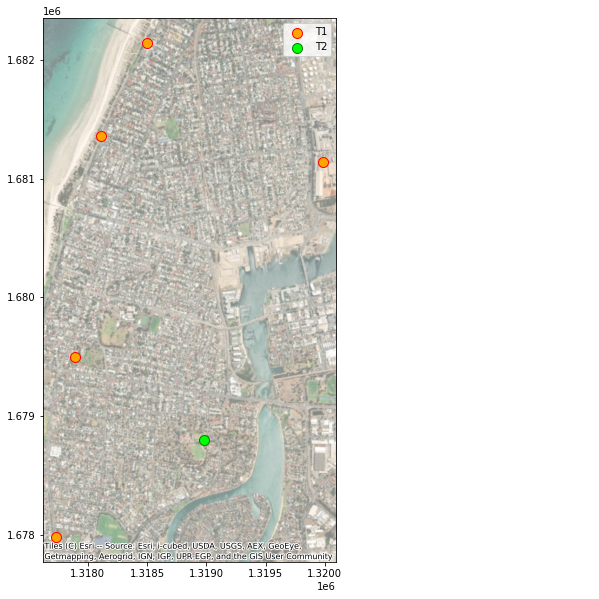

In [43]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
t_wells[t_wells.aq_mon == "Tomw(T1)"].geometry.plot(fc='orange', ec='r', marker='o', markersize=100, ax=ax, label="T1")
t_wells[t_wells.aq_mon == "Tomw(T2)"].geometry.plot(fc='lime', ec='green', marker='o', markersize=100, ax=ax, label="T2")
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)
ax.legend()

In [39]:
t_wells

,dhno,lat,lon,mapnum,unit_no,max_depth,aq_mon,swl,tds,class,...,stat_desc,yield,latest_yield_date,permit_no,replaceunitnum,geometry,obsnumber,obsnetwork,swlstatus,salstatus
125,206608,-34.832417,138.482484,652802547.0,6528-2547,154.00,Tomw(T1),NaN,NaN,Strat,...,NaN,NaN,NaN,NaN,NaN,POINT (1318112.381 1681362.329),NaN,NaN,NaN,NaN
5,27545,-34.849275,138.480715,652800417.0,6528-417,103.02,Tomw(T1),9.14,7600.0,WW,...,BKF,NaN,NaN,NaN,NaN,POINT (1317890.673 1679500.593),NaN,NaN,NaN,NaN
9,27582,-34.863053,138.479540,652800454.0,6528-454,173.13,Tomw(T1),9.75,3027.0,WW,...,UKN,17.68,1951-07-20,NaN,NaN,POINT (1317734.239 1677978.288),NaN,NaN,NaN,NaN
13,27587,-34.855317,138.492849,652800459.0,6528-459,198.12,Tomw(T2),5.18,2792.0,WW,...,BKF,19.32,1971-08-23,254671.0,NaN,POINT (1318976.834 1678795.808),NaN,NaN,NaN,NaN
0,27150,-34.825235,138.486454,652800003.0,6528-3,92.96,Tomw(T1),3.05,1385.0,PW,...,ABD,1.00,1931-12-01,NaN,NaN,POINT (1318500.576 1682145.994),NaN,NaN,NaN,NaN
75,51506,-34.833889,138.503017,662804537.0,6628-4537,108.20,Tomw(T1),3.66,2585.0,WW,...,NaN,15.15,1960-03-16,NaN,NaN,POINT (1319982.052 1681138.785),NaN,NaN,NaN,NaN


## Searching by location and radius

Let's look for wells near a mine like Prominent Hill:

using a radius search of 30 km

In [41]:
lat = -29.827870
lon = 135.610701
radius_km = 30

wells = session.search_by_radius(lat, lon, radius_km).gdf()

In [42]:
wells

,dhno,lat,lon,mapnum,max_depth,drill_date,swl,tds,stat_desc,class,...,permit_no,yield,latest_yield_date,aq_mon,obsnumber,obsnetwork,swlstatus,salstatus,replaceunitnum,geometry
0,9758,-30.005110,135.399494,593700062.0,30.78,1962-05-08,21.64,743.0,ABD,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1038474.665 2220612.762)
1,9759,-30.025724,135.413100,593700063.0,33.53,1962-05-02,NaN,NaN,ABD,WW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1039776.274 2218326.882)
2,9820,-30.024907,135.455566,593700124.0,130.00,1981-01-01,NaN,NaN,UKN,MW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1043865.490 2218400.843)
3,332884,-30.053247,135.479734,593700537.0,65.50,2019-12-02,54.00,6977.0,OPR,WW,...,342340.0,1.00,2019-12-02,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1046178.585 2215255.049)
4,9968,-29.871678,135.345502,593800010.0,89.47,1930-01-01,77.87,7609.0,NIU,WW,...,NaN,0.42,1952-07-30,K-c(unconf),NaN,NaN,NaN,NaN,NaN,POINT (1033322.122 2235395.592)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,371260,-29.976768,135.654835,603800689.0,351.10,2006-10-14,NaN,NaN,NaN,MW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1063084.495 2223628.813)
980,371261,-29.960878,135.623841,603800690.0,70.00,2006-10-22,NaN,NaN,NaN,MW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1060108.811 2225404.755)
981,371262,-29.964527,135.654839,603800691.0,96.00,2006-11-21,NaN,NaN,NaN,MW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1063093.033 2224983.309)
982,371263,-29.968547,135.686714,603800692.0,86.00,2006-11-18,NaN,NaN,NaN,MW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (1066161.250 2224519.421)


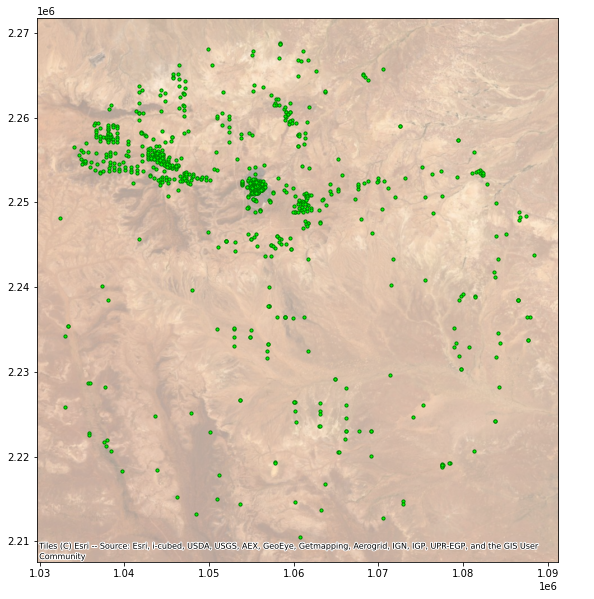

In [46]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
wells.geometry.plot(fc='lime', ec='green', marker='o', markersize=10, ax=ax)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)

Let's also put the search point on this map so we can see what happened

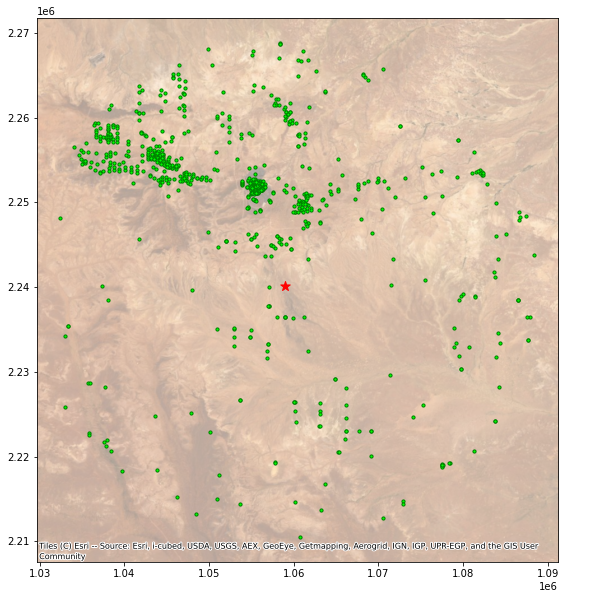

<Figure size 432x288 with 0 Axes>

In [47]:
search_df = pd.DataFrame({'lat': [lat], 'lon': [lon]})
search_pts = gpd.GeoDataFrame(
    search_df, crs="EPSG:4326", geometry=gpd.points_from_xy(search_df.lon, search_df.lat)
).to_crs(session.working_crs)

search_pts.geometry.plot(marker='*', c='red', markersize=100, label='Search point', ax=ax, aspect=1)

ax.figure

## Searching by a rectangle

Let's search for wells in a rectangle - shall we try to retrieve a cross section of wells across the Adelaide Plains below the Para Fault?

I'll need to get the latitude and longitude of the:

- south-western corner i.e. **bottom left** (min latitude and min longitude) and the
- north-eastern corner i.e. **top right** (max latitude and max longitude)

In [3]:
ne_corner = -34.901291, 138.484388
sw_corner = -34.941296, 138.625417

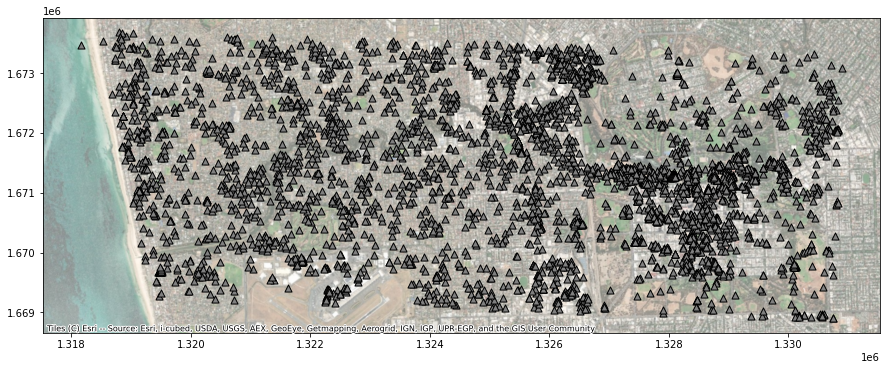

In [5]:
wells = session.search_by_rect(ne_corner, sw_corner).gdf()
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
wells.geometry.plot(fc='grey', ec='black', marker='^', markersize=50, ax=ax)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, crs=session.working_crs, alpha=0.5)